In [1]:
import pairTrade
from pairTrade import pairTrade
import pandas as pd
import warnings
import pandas.util.testing as tm
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts 
warnings.filterwarnings('ignore')

symbols = pd.read_csv(f"/Users/jochien/Documents/MaxRereach/pair-trade/rawdata/1D/symbols.csv").symbol.tolist()
df = ((pd.concat([pd.read_csv(f"/Users/jochien/Documents/MaxRereach/pair-trade/rawdata/1D/{symbol}.csv", index_col='date', parse_dates=True)
        ['close'].rename(symbol)for symbol in symbols],axis=1,sort=True)))
df = df.loc[:,~df.columns.duplicated()]

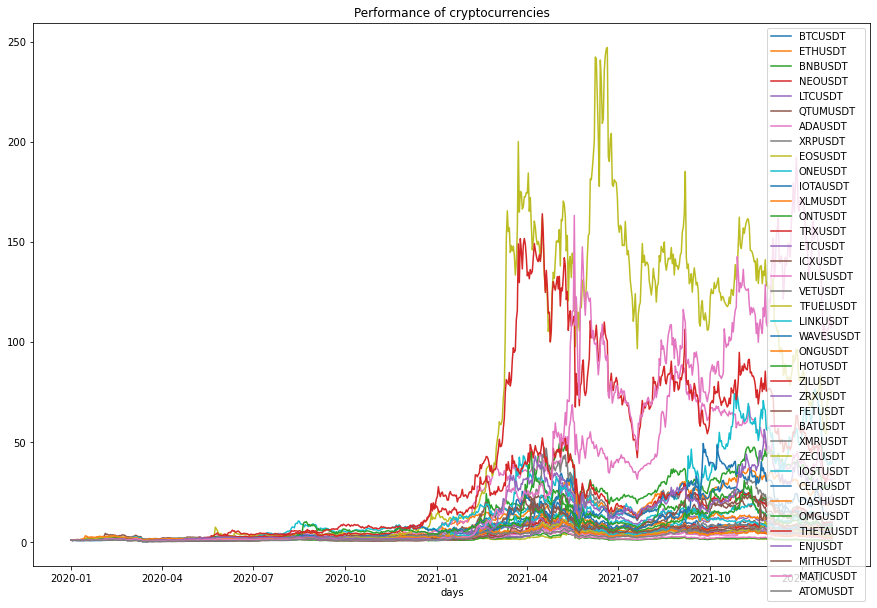

ETHUSDT and BNBUSDT: p-value = 0.03979705332444582
ETHUSDT and FETUSDT: p-value = 0.009294446232473275
ETHUSDT and ATOMUSDT: p-value = 0.023721913440312683
BNBUSDT and ETHUSDT: p-value = 0.04184327180902625
BNBUSDT and ONEUSDT: p-value = 0.017484822695047326
BNBUSDT and TFUELUSDT: p-value = 0.03356023967788704
BNBUSDT and ONGUSDT: p-value = 0.017847752585666694
BNBUSDT and HOTUSDT: p-value = 0.03491978636054913
BNBUSDT and FETUSDT: p-value = 0.04605206033659679
BNBUSDT and CELRUSDT: p-value = 0.018390725167988196
BNBUSDT and ENJUSDT: p-value = 0.02378173173397498
BNBUSDT and MATICUSDT: p-value = 0.038107528953613565
NEOUSDT and TFUELUSDT: p-value = 0.0001684619737509815
NEOUSDT and HOTUSDT: p-value = 0.018482944552887164
NEOUSDT and ZILUSDT: p-value = 0.025957842103161946
NEOUSDT and THETAUSDT: p-value = 2.6834950126713157e-07
LTCUSDT and BTCUSDT: p-value = 0.03861984946462687
LTCUSDT and IOTAUSDT: p-value = 0.0190484896026411
LTCUSDT and XLMUSDT: p-value = 0.00039515054718914565
LTCUS

WAVESUSDT and TRXUSDT: p-value = 0.01116972877720734
WAVESUSDT and VETUSDT: p-value = 0.015683923691441275
WAVESUSDT and TFUELUSDT: p-value = 0.001632307403118933
WAVESUSDT and ONGUSDT: p-value = 8.897822036597178e-05
WAVESUSDT and HOTUSDT: p-value = 0.006923414180555478
WAVESUSDT and FETUSDT: p-value = 0.0023848624756069073
WAVESUSDT and OMGUSDT: p-value = 0.042239187944367554
WAVESUSDT and THETAUSDT: p-value = 0.01907919031528317
ONGUSDT and ETHUSDT: p-value = 0.03418164222454803
ONGUSDT and BNBUSDT: p-value = 0.009574291195622732
ONGUSDT and QTUMUSDT: p-value = 0.022383863688809253
ONGUSDT and ADAUSDT: p-value = 0.009979372077112915
ONGUSDT and XRPUSDT: p-value = 0.005212552926376681
ONGUSDT and IOTAUSDT: p-value = 0.03279373127168058
ONGUSDT and TRXUSDT: p-value = 0.0018682625614575505
ONGUSDT and VETUSDT: p-value = 0.0014384162716002712
ONGUSDT and TFUELUSDT: p-value = 0.03851453444051624
ONGUSDT and WAVESUSDT: p-value = 0.00010944247282061185
ONGUSDT and HOTUSDT: p-value = 0.0098

MITHUSDT and DASHUSDT: p-value = 0.006560933853022412
MITHUSDT and THETAUSDT: p-value = 0.0006217928037544199
MATICUSDT and BNBUSDT: p-value = 0.03431794557039632
MATICUSDT and ONEUSDT: p-value = 0.03274629846865262
MATICUSDT and CELRUSDT: p-value = 0.03781541470290243
ATOMUSDT and ETHUSDT: p-value = 0.014003139677686655
ATOMUSDT and ONEUSDT: p-value = 0.0030698077520654433
ATOMUSDT and FETUSDT: p-value = 0.03033057537430436
ATOMUSDT and BATUSDT: p-value = 0.023245696792688585
ATOMUSDT and CELRUSDT: p-value = 0.01721653317572078
ATOMUSDT and ENJUSDT: p-value = 0.0074358629487091725


In [2]:
norm_prices = df.divide(df.iloc[0])

plt.figure(figsize = (15, 10))
plt.plot(norm_prices)
plt.xlabel('days')
plt.title('Performance of cryptocurrencies')
plt.legend(symbols)
plt.show()

result_list = []
for a1 in df.columns:
    for a2 in df.columns:
        if a1 != a2:
            test_result = ts.coint(df[a1], df[a2])
            if test_result[1] < 0.05:
                print(a1 + ' and ' + a2 + ': p-value = ' + str(test_result[1]))
                result_list.append((a1, a2, test_result[1]))

* tradeType(ratio, spread, returnSpread, regression)
* strategyType: convergence 收斂策略, divergence 發散策略
* actionType: amount等金額購買, unit依比例購買
* entry 進場條件
* exit 出場條件
* stopLoss 訊號停損
* singalStopLoss{固定停利停損 : stopLoss, 移動停利停損 : trailingStop, 時間停利停損 : timeStop} 
* stopLossPara 停損參數 : stopLoss 固定停利停損點位, trailingStop 移動停利停損點位, timeStop 時間停利停損時間間隔

# Ratio

### singal stoploss

MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  27723.68179099
總交易次數:  49
平均損益:  565.7894243059602
勝率:  0.5510204081632653
獲利因子:  1.2717493618094458
賺賠比:  1.0362402207336223
最大資金回落:  29590.60453465642
夏普比率:  0.07621456213037531


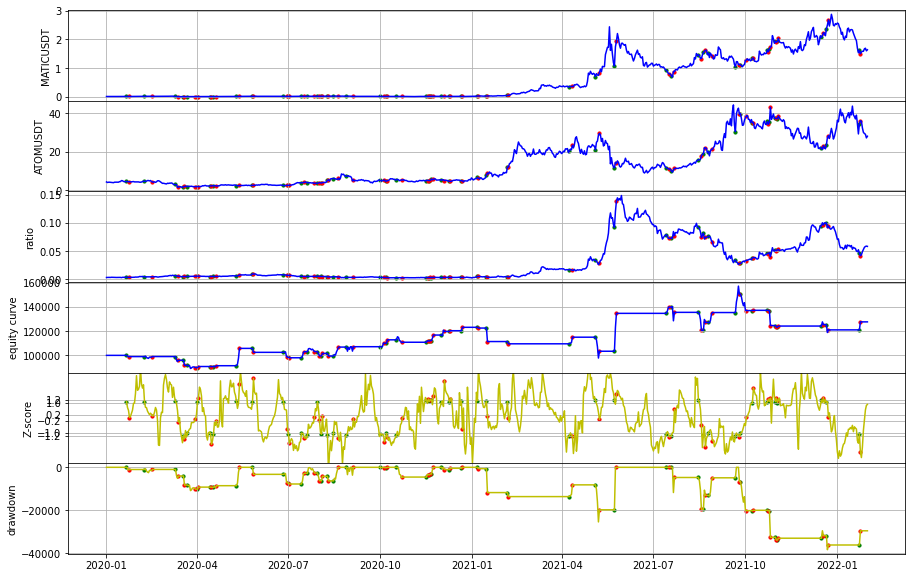

In [3]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2)
A.pplot()

### stopLoss

[Stop-loss point] 2021-05-07 00:00:00
[Stop-loss point] 2021-05-24 00:00:00
[Stop-loss point] 2021-07-21 00:00:00
[Stop-loss point] 2021-09-23 00:00:00
[Stop-loss point] 2021-10-01 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  3312.32746140
總交易次數:  49
平均損益:  67.59851962036741
勝率:  0.5510204081632653
獲利因子:  1.031810156861627
賺賠比:  0.8407342018872516
最大資金回落:  25467.435658655973
夏普比率:  0.010737724788814657


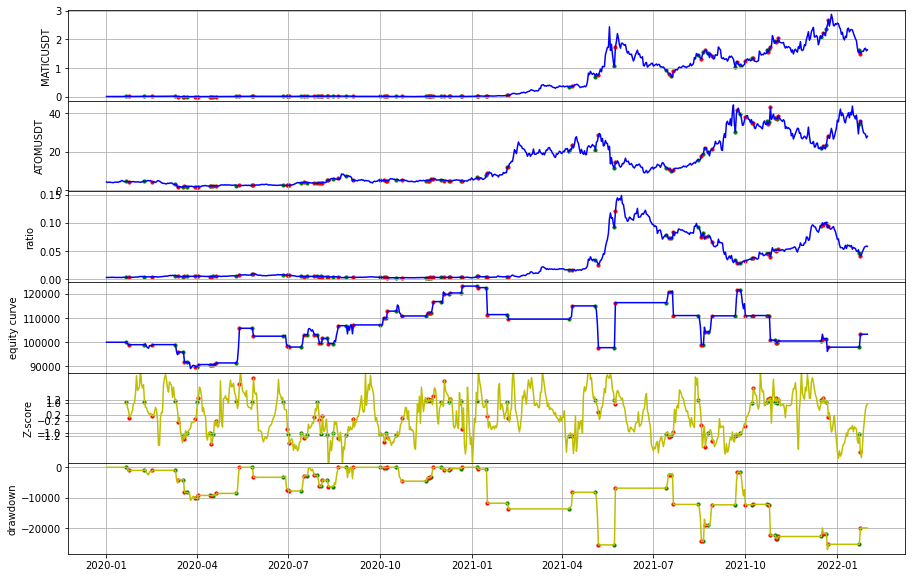

In [4]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

[Stop-loss point] 2021-05-07 00:00:00 115042.5022533471
[Stop-loss point] 2021-07-21 00:00:00 132673.6046024664
[Stop-loss point] 2021-10-01 00:00:00 135076.1715825666
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  14728.18187107
總交易次數:  49
平均損益:  300.575140225903
勝率:  0.5510204081632653
獲利因子:  1.1350976453730035
賺賠比:  0.9248943777113361
最大資金回落:  26297.39011512563
夏普比率:  0.04072975313204315


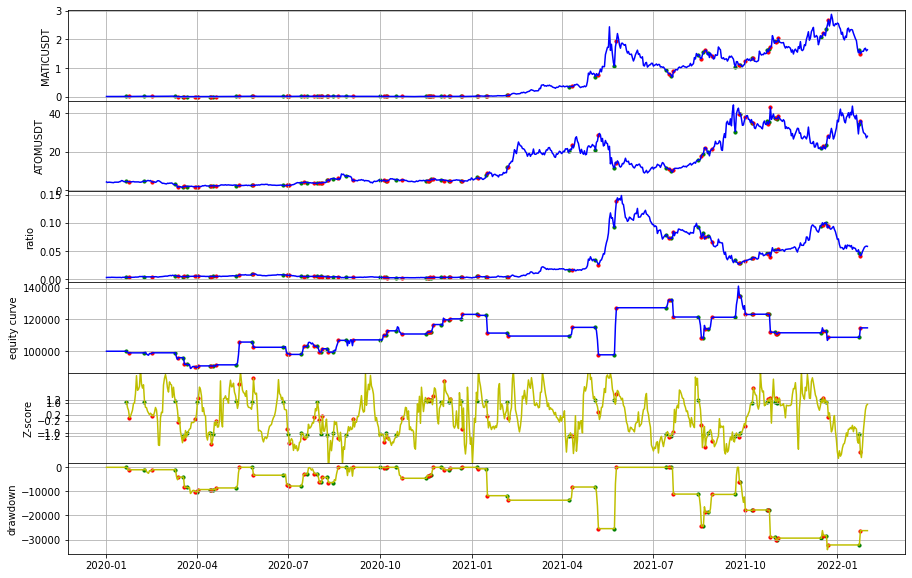

In [5]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

[Stop-loss point] 2020-02-11 00:00:00
[Stop-loss point] 2020-03-25 00:00:00
[Stop-loss point] 2020-06-29 00:00:00
[Stop-loss point] 2020-07-23 00:00:00
[Stop-loss point] 2020-08-18 00:00:00
[Stop-loss point] 2020-08-31 00:00:00
[Stop-loss point] 2020-10-04 00:00:00
[Stop-loss point] 2020-10-20 00:00:00
[Stop-loss point] 2021-05-07 00:00:00
[Stop-loss point] 2021-08-28 00:00:00
[Stop-loss point] 2021-09-24 00:00:00
[Stop-loss point] 2021-09-29 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  23701.98004746
總交易次數:  49
平均損益:  483.7138785195985
勝率:  0.5102040816326531
獲利因子:  1.2342468804919657
賺賠比:  1.184877005272287
最大資金回落:  24546.501312130975
夏普比率:  0.06673576088420753


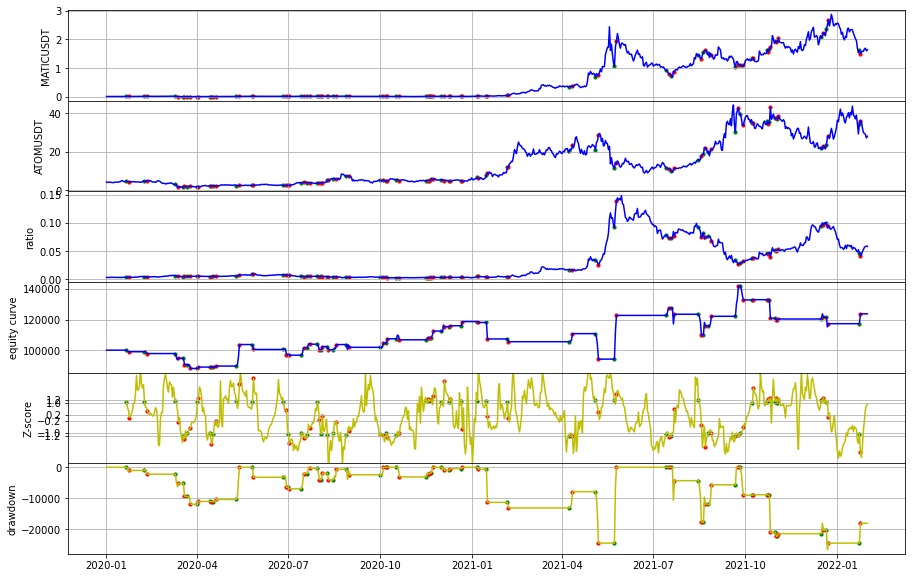

In [6]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'ratio')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()

# Spread

### singal stoploss

MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  51922.99990498
總交易次數:  45
平均損益:  1153.8444423329033
勝率:  0.6222222222222222
獲利因子:  1.7174662772987306
賺賠比:  1.0427473826456577
最大資金回落:  24222.095792234148
夏普比率:  0.1598937489197541


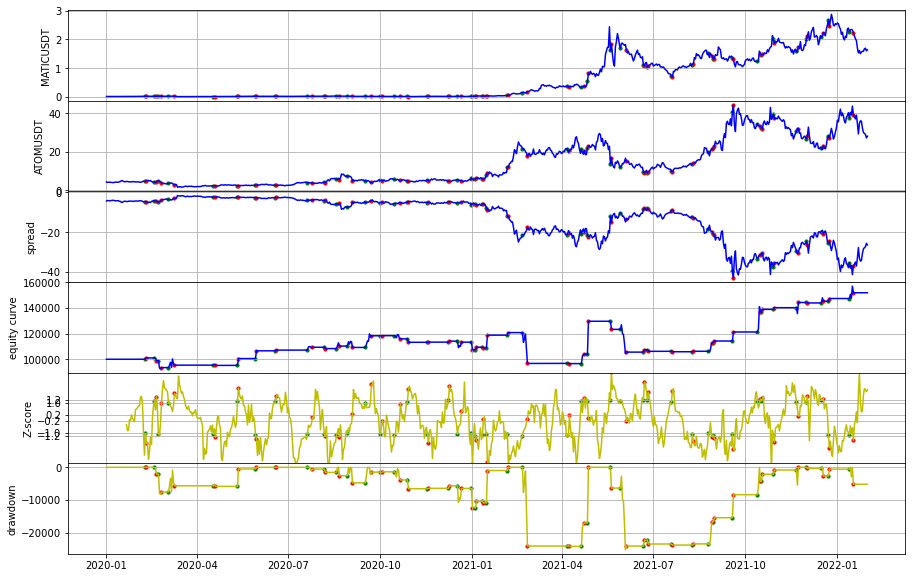

In [7]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2)
A.pplot()

### stopLoss

[Stop-loss point] 2020-09-20 00:00:00
[Stop-loss point] 2021-02-24 00:00:00
[Stop-loss point] 2021-06-02 00:00:00
[Stop-loss point] 2021-10-15 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  89348.56561193
總交易次數:  45
平均損益:  1985.5236802652018
勝率:  0.6222222222222222
獲利因子:  2.5732402538379078
賺賠比:  1.5623244398301581
最大資金回落:  19104.947142521647
夏普比率:  0.2781931039620331


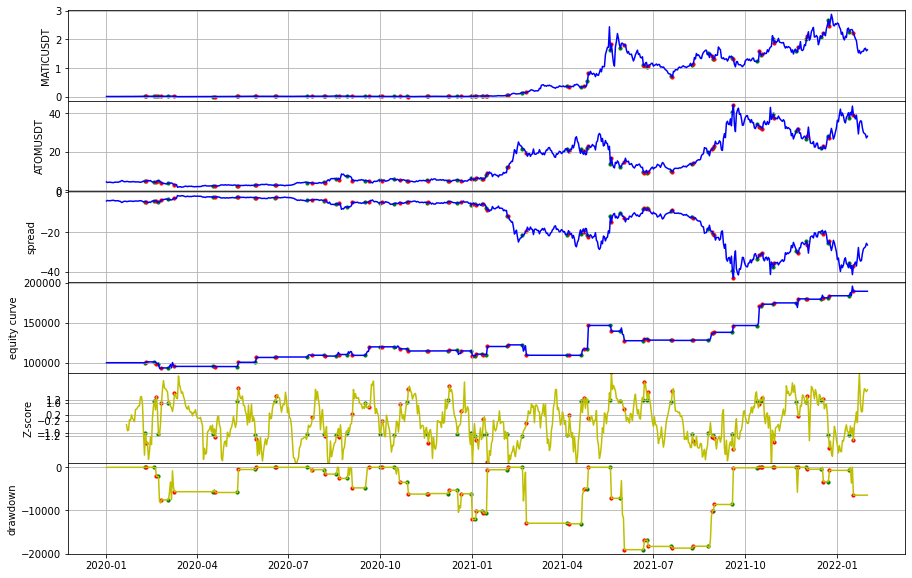

In [8]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

[Stop-loss point] 2021-02-24 00:00:00 120814.09828563829
[Stop-loss point] 2021-06-02 00:00:00 141763.96310087445
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  81269.56452870
總交易次數:  45
平均損益:  1805.9903228599235
勝率:  0.6222222222222222
獲利因子:  2.4460218270920646
賺賠比:  1.4850846807344678
最大資金回落:  18870.166787566937
夏普比率:  0.2697681877610205


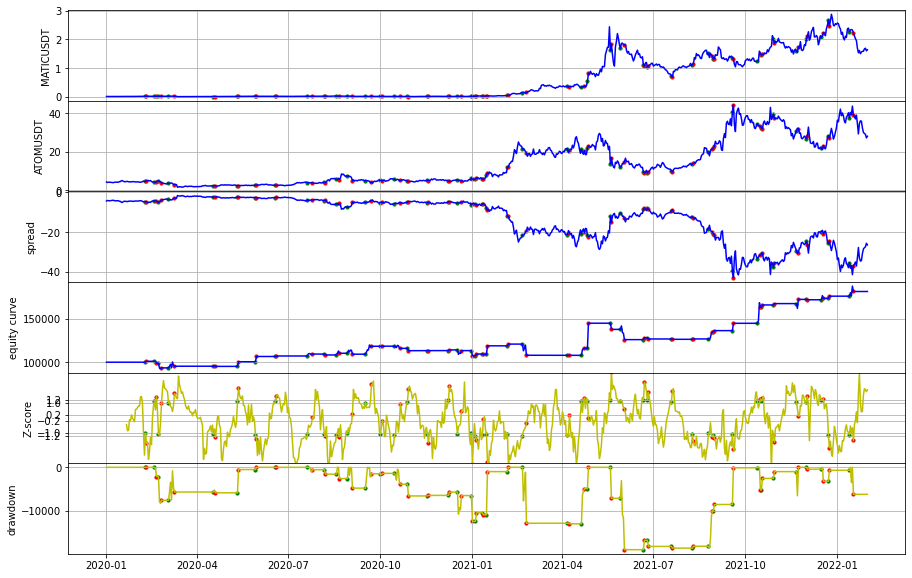

In [9]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

[Stop-loss point] 2020-03-06 00:00:00
[Stop-loss point] 2020-07-23 00:00:00
[Stop-loss point] 2020-09-01 00:00:00
[Stop-loss point] 2020-09-19 00:00:00
[Stop-loss point] 2020-10-18 00:00:00
[Stop-loss point] 2020-12-20 00:00:00
[Stop-loss point] 2021-02-23 00:00:00
[Stop-loss point] 2021-06-01 00:00:00
[Stop-loss point] 2021-08-28 00:00:00
[Stop-loss point] 2022-01-16 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  115127.58622410
總交易次數:  45
平均損益:  2558.390804979914
勝率:  0.6666666666666666
獲利因子:  3.9985012925511896
賺賠比:  1.9992506462755946
最大資金回落:  12645.834123864537
夏普比率:  0.3811941444266587


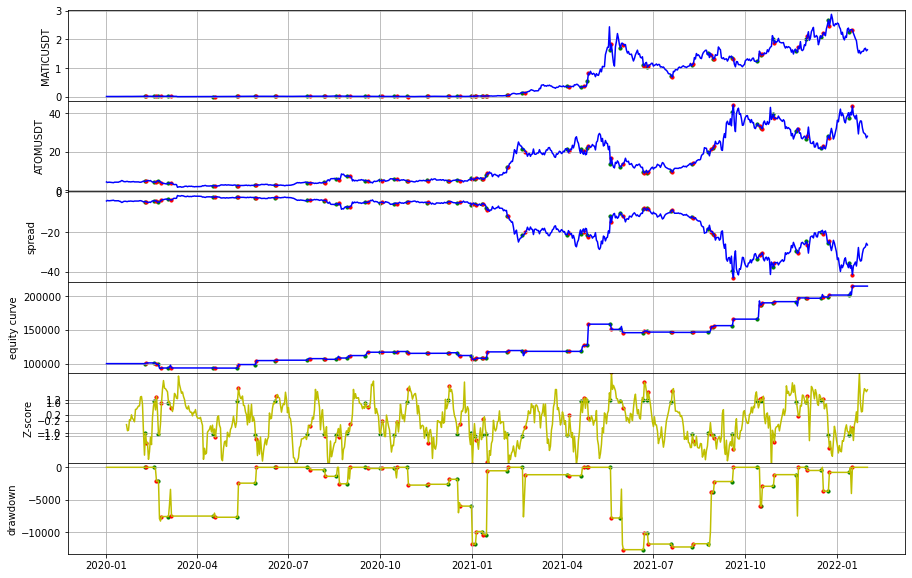

In [10]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'spread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()

# returnSpread

### singal stoploss

MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -37355.32584059
總交易次數:  47
平均損益:  -794.7941668211096
勝率:  0.40425531914893614
獲利因子:  0.6257055974844693
賺賠比:  0.9220924594507969
最大資金回落:  50934.3321149391
夏普比率:  -0.12904198614813153


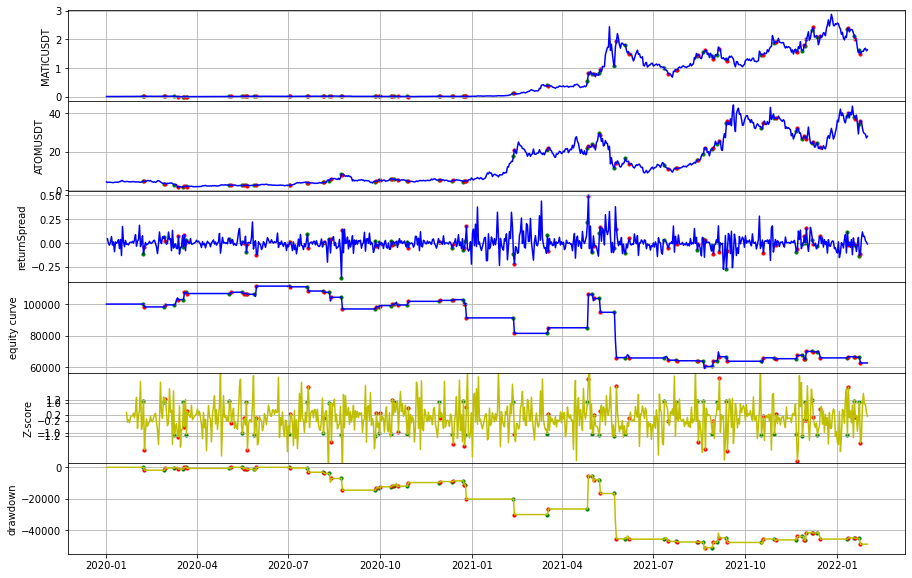

In [11]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2)
A.pplot()

### stopLoss

[Stop-loss point] 2021-05-24 00:00:00
[Stop-loss point] 2021-09-04 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -23881.41924254
總交易次數:  47
平均損益:  -508.1153030327668
勝率:  0.40425531914893614
獲利因子:  0.7433644429221534
賺賠比:  1.0954844422010683
最大資金回落:  41153.53318210428
夏普比率:  -0.09362105967249407


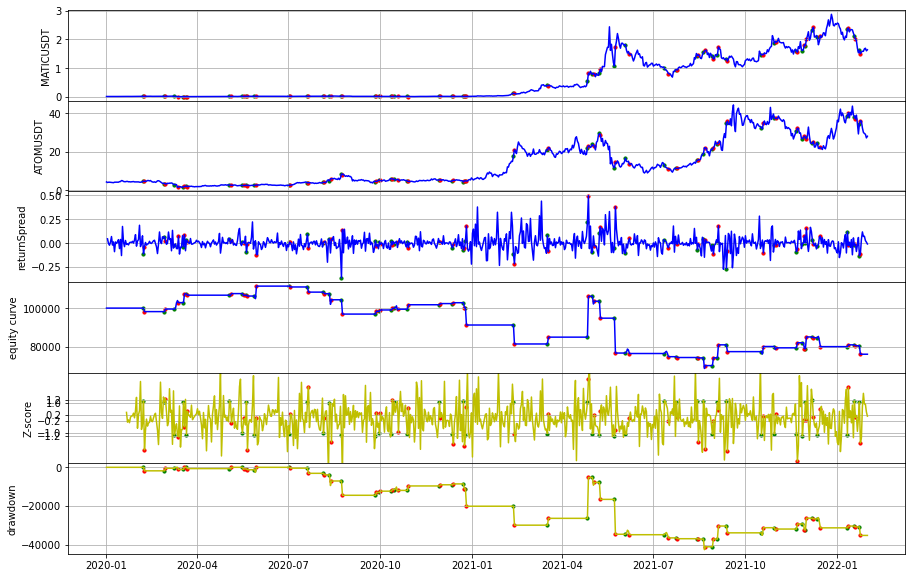

In [12]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

[Stop-loss point] 2021-05-24 00:00:00 94785.79670323148
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -27219.16103507
總交易次數:  47
平均損益:  -579.1310858525791
勝率:  0.40425531914893614
獲利因子:  0.7051141092259002
賺賠比:  1.0391155293855372
最大資金回落:  41153.53318210428
夏普比率:  -0.10863545155774292


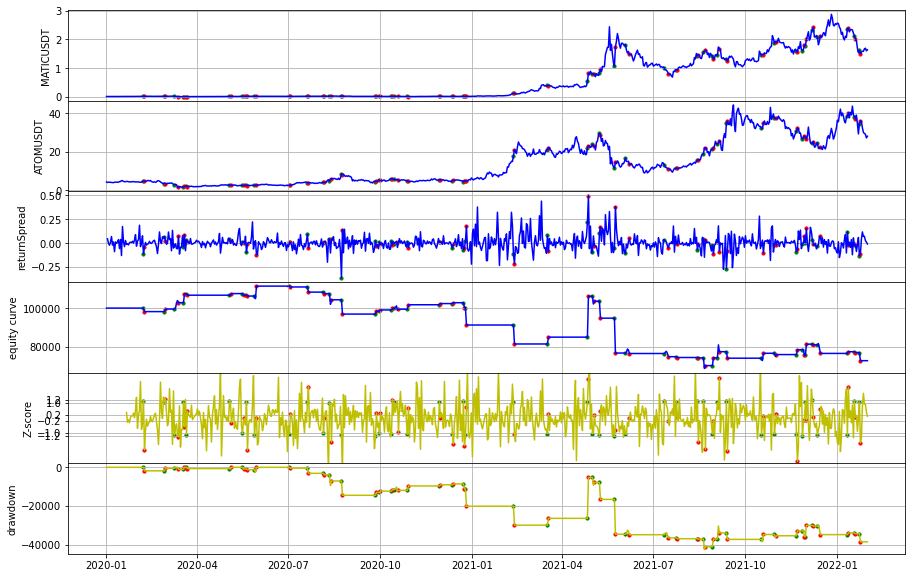

In [13]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

[Stop-loss point] 2020-03-12 00:00:00
[Stop-loss point] 2020-10-18 00:00:00
[Stop-loss point] 2021-06-06 00:00:00
[Stop-loss point] 2021-07-15 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -34049.36842584
總交易次數:  47
平均損益:  -724.4546473583292
勝率:  0.44680851063829785
獲利因子:  0.6598970574038071
賺賠比:  0.8170154044047137
最大資金回落:  48919.61343137219
夏普比率:  -0.11604482470745642


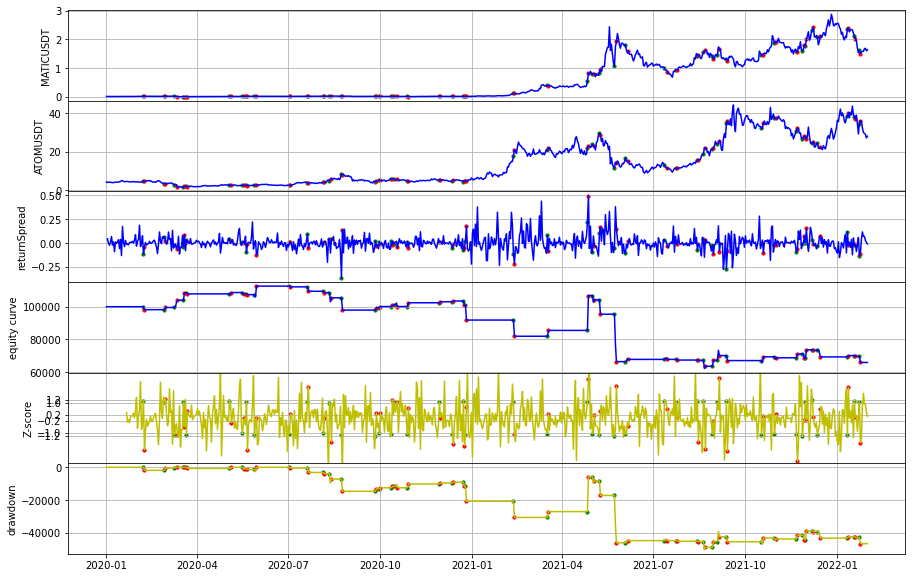

In [14]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'returnSpread')
A.strategy(strategyType = 'divergence', actionType = 'amount', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()

# regression

### singal stoploss

MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -4707.49036104
總交易次數:  42
平均損益:  -112.08310383423616
勝率:  0.6190476190476191
獲利因子:  0.9740876366489477
賺賠比:  0.5994385456301217
最大資金回落:  71308.19500947867
夏普比率:  -0.008157493707212997


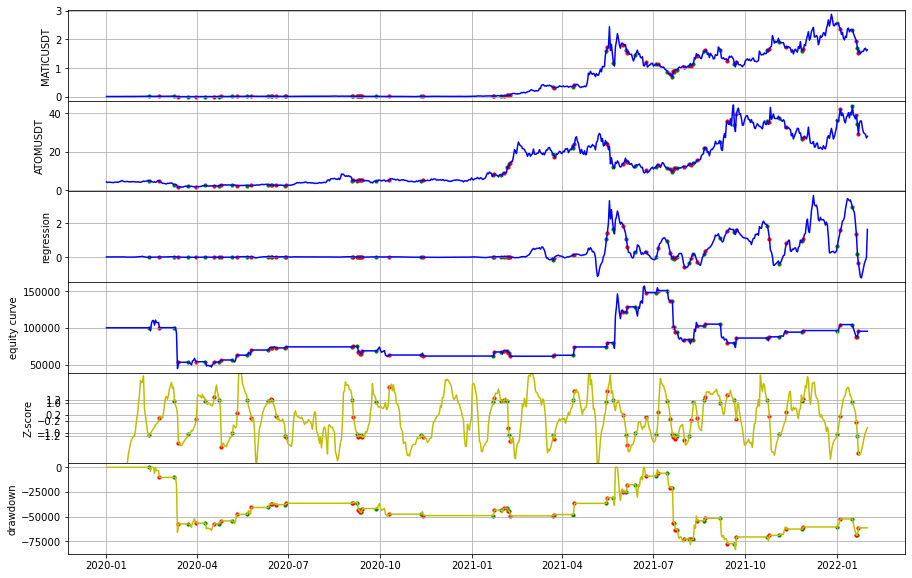

In [15]:
# for i in result_list[:1]:
# df1 = df[[i[0], i[1]]]
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, singalStopLoss = 1.2)
A.pplot()

### stopLoss

[Stop-loss point] 2020-02-16 00:00:00
[Stop-loss point] 2020-03-12 00:00:00
[Stop-loss point] 2020-03-29 00:00:00
[Stop-loss point] 2020-04-10 00:00:00
[Stop-loss point] 2020-05-10 00:00:00
[Stop-loss point] 2020-10-06 00:00:00
[Stop-loss point] 2021-05-23 00:00:00
[Stop-loss point] 2021-06-15 00:00:00
[Stop-loss point] 2021-07-17 00:00:00
[Stop-loss point] 2021-07-27 00:00:00
[Stop-loss point] 2021-08-11 00:00:00
[Stop-loss point] 2021-09-07 00:00:00
[Stop-loss point] 2021-11-10 00:00:00
[Stop-loss point] 2022-01-18 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -53512.32423629
總交易次數:  42
平均損益:  -1274.1029580069483
勝率:  0.5714285714285714
獲利因子:  0.6191039423753324
賺賠比:  0.46432795678149924
最大資金回落:  74953.44879321806
夏普比率:  -0.12080828611141234


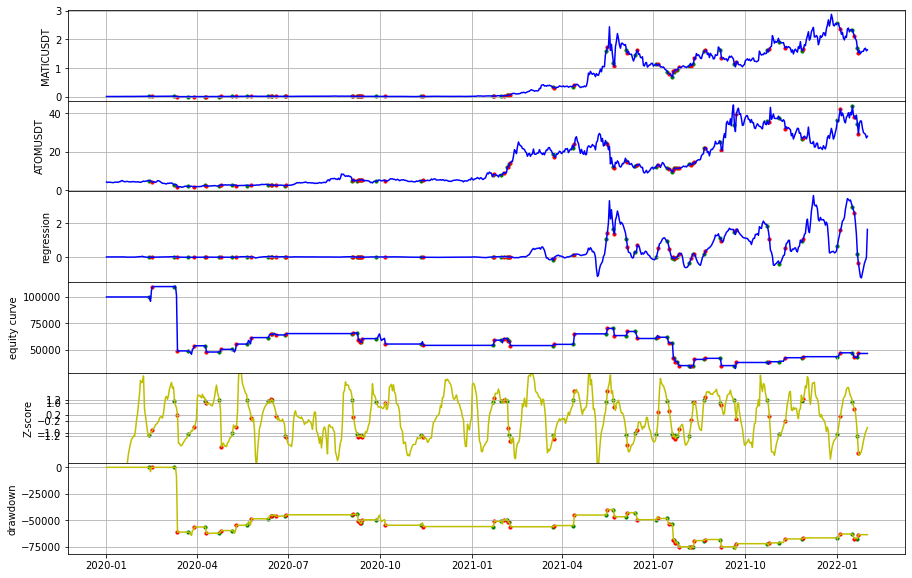

In [17]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'stopLoss', stopLossPara = 0.08)
A.pplot()

### trailingStop

[Stop-loss point] 2020-03-12 00:00:00 100556.6839574069
[Stop-loss point] 2020-04-10 00:00:00 45242.458534261685
[Stop-loss point] 2020-10-02 00:00:00 55620.778832480406
[Stop-loss point] 2021-05-23 00:00:00 63698.583166907316
[Stop-loss point] 2021-06-15 00:00:00 61014.32072565096
[Stop-loss point] 2021-07-17 00:00:00 56066.966372281575
[Stop-loss point] 2021-07-27 00:00:00 35169.575590730004
[Stop-loss point] 2021-09-07 00:00:00 39669.94389039766
[Stop-loss point] 2022-01-18 00:00:00 43604.045390087434
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -56972.26586571
總交易次數:  42
平均損益:  -1356.4825206120545
勝率:  0.5714285714285714
獲利因子:  0.5409688824013257
賺賠比:  0.40572666180099426
最大資金回落:  68540.64845704683
夏普比率:  -0.14357181860808993


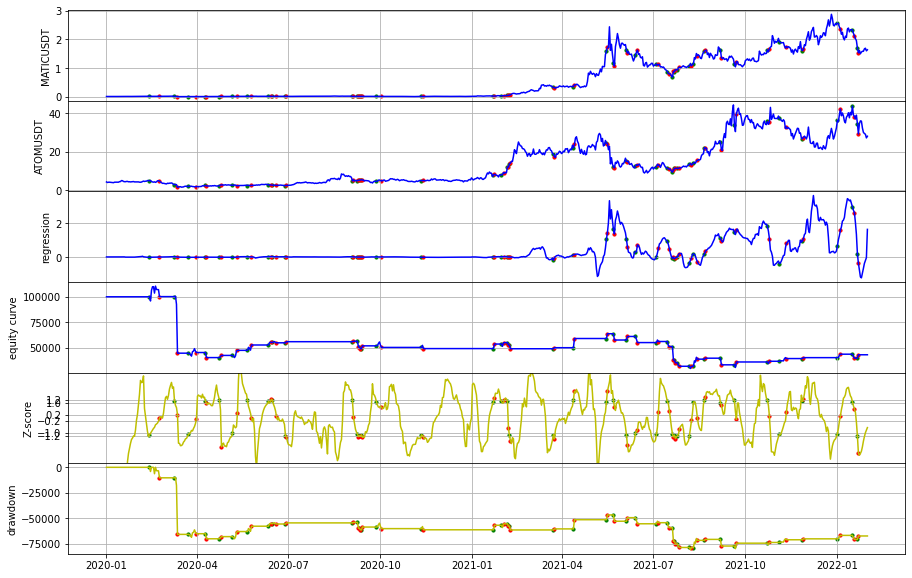

In [18]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'trailingStop', stopLossPara = 0.08)
A.pplot()

### timeStop

[Stop-loss point] 2020-02-16 00:00:00
[Stop-loss point] 2020-03-12 00:00:00
[Stop-loss point] 2020-03-26 00:00:00
[Stop-loss point] 2020-04-12 00:00:00
[Stop-loss point] 2020-05-09 00:00:00
[Stop-loss point] 2020-05-24 00:00:00
[Stop-loss point] 2020-06-18 00:00:00
[Stop-loss point] 2020-09-30 00:00:00
[Stop-loss point] 2021-05-25 00:00:00
[Stop-loss point] 2021-06-16 00:00:00
[Stop-loss point] 2021-07-28 00:00:00
[Stop-loss point] 2021-08-13 00:00:00
[Stop-loss point] 2021-09-09 00:00:00
[Stop-loss point] 2021-11-07 00:00:00
[Stop-loss point] 2022-01-19 00:00:00
MATICUSDT_ATOMUSDT 回測結果
-----------------------------MATICUSDT-ATOMUSDT--------------------------
初始價格 100000
總損益:  -25469.50558914
總交易次數:  42
平均損益:  -606.4167997415236
勝率:  0.5952380952380952
獲利因子:  0.828000135187342
賺賠比:  0.5630400919273925
最大資金回落:  69205.58241581937
夏普比率:  -0.04819405337561487


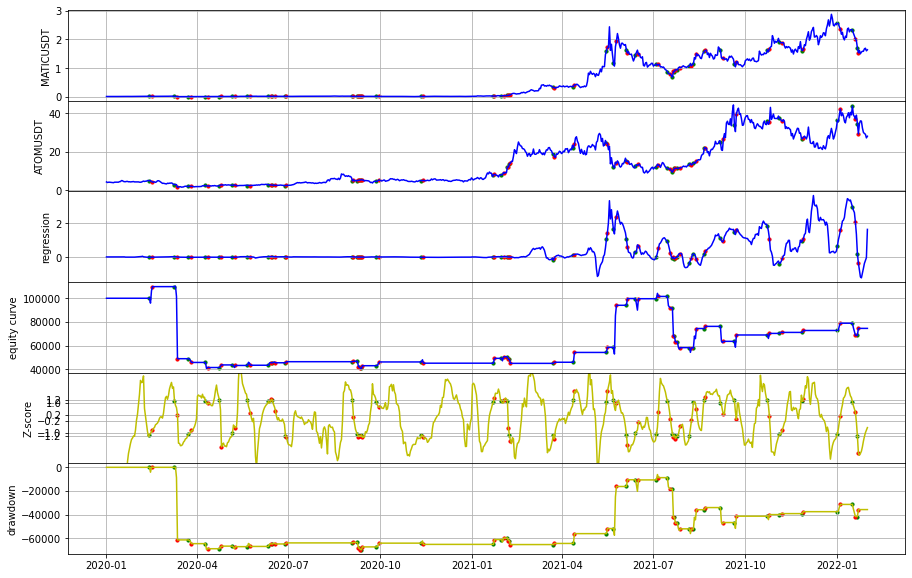

In [19]:
df1 = df[['MATICUSDT', 'ATOMUSDT']]
A = pairTrade(df1)
A.indicator(tradeType = 'regression')
A.strategy(strategyType = 'divergence', actionType = 'unit', entry = 1, exit = 0.2, singalStopLoss = 1.2, stopLossType = 'timeStop', stopLossPara = 3)
A.pplot()